In [8]:
!date

Wed Apr  9 05:26:35 PM EDT 2025


In [9]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

In [10]:
import os
import numpy as np
import pandas as pd
import ants
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm
import seaborn as sns

In [11]:
def load_pickle(fn):
    if os.path.exists(fn):
        with open(fn, 'rb') as file:
            loaded_dict = pickle.load(file)
    return loaded_dict

In [12]:
analysis_name = 'DeepCor-ABCD-v3'
#analysis_name = 'DeepCor-ABCD-v1'
analysis_dir = os.path.join('../Data/StudyForrest/ensembles_last_CVAE/',analysis_name)

<AxesSubplot:>

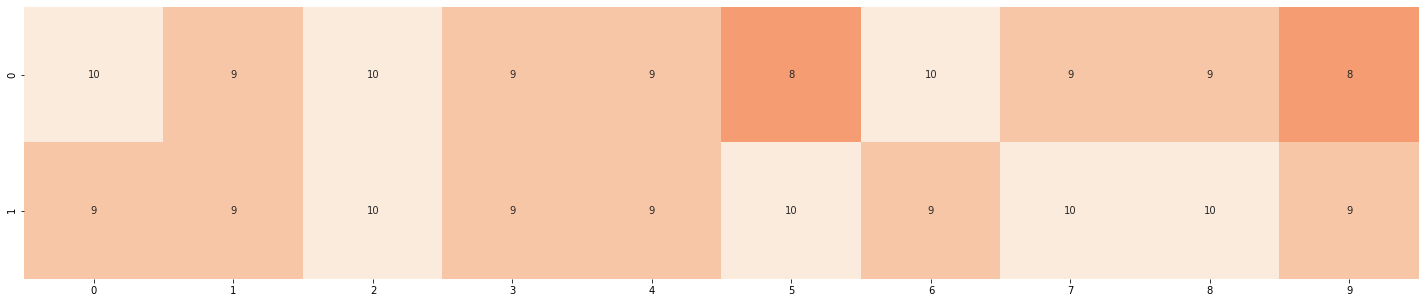

In [14]:
nsubs = 10
nruns = 2
check_done = np.zeros((nruns,nsubs))
for s in range(nsubs):
    for r in np.arange(nruns):
        check_done[r,s] = sum([os.path.exists(os.path.join(analysis_dir,f'outputs_S{s}_R{r+1}_rep_{rep}.pickle')) for rep in range(10)])
        
plt.figure(figsize=(25,5))
sns.heatmap(check_done,annot=True,cbar=False,vmin=0,vmax=10)

Text(0.5, 0.98, 'ABCD S3 R2')

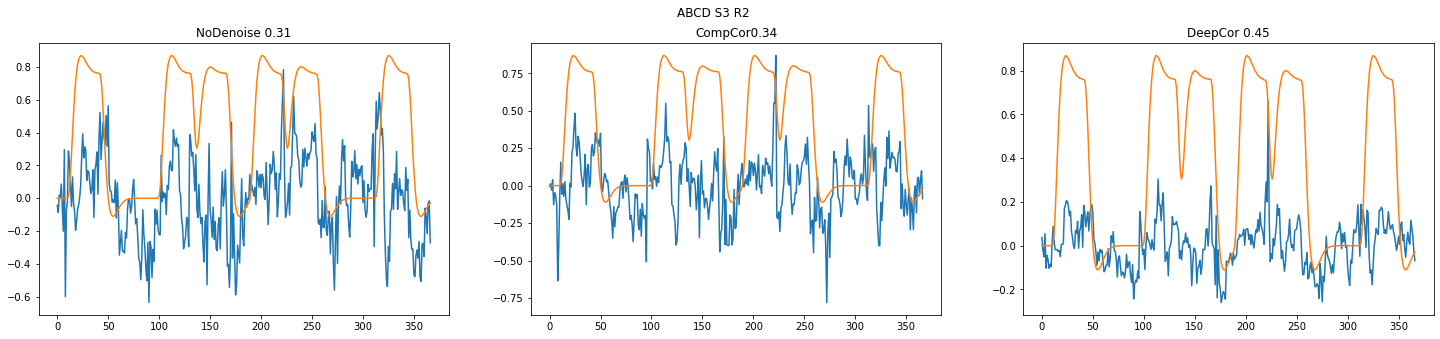

In [50]:
s=3
r=2
output_files = [os.path.join(analysis_dir,val) for val in os.listdir(analysis_dir) if val.startswith(f'outputs_S{s}_R{r}_')]

vals_ffa = load_pickle(output_files[0])['ffa']
vals_compcor = load_pickle(output_files[0])['ffa_compcorr']
face_reg = load_pickle(output_files[0])['face_reg']
vals_signals = np.array([load_pickle(output_file)['signal'] for output_file in output_files])
vals_signals_med = np.median(vals_signals,0)


plt.figure(figsize=(25,5))
plt.subplot(1,3,1);
plt.plot(vals_ffa.mean(axis=0));
plt.plot(face_reg)
c = np.corrcoef(vals_ffa.mean(axis=0),face_reg)[0,1]
plt.title(f'NoDenoise {c:.2f}')



plt.subplot(1,3,2);
plt.plot(vals_compcor.mean(axis=0));
plt.plot(face_reg)
c = np.corrcoef(vals_compcor.mean(axis=0),face_reg)[0,1]
plt.title(f'CompCor{c:.2f}')


plt.subplot(1,3,3);
plt.plot(vals_signals_med.mean(axis=0));
plt.plot(face_reg)
c = np.corrcoef(vals_signals_med.mean(axis=0),face_reg)[0,1]
plt.title(f'DeepCor {c:.2f}')

plt.suptitle(f'ABCD S{s} R{r}')

In [19]:
def get_sub_data(s,r):
    output_files = [os.path.join(analysis_dir,val) for val in os.listdir(analysis_dir) if val.startswith(f'outputs_S{s}_R{r}_')]
    vals_ffa = load_pickle(output_files[0])['ffa']
    vals_compcor = load_pickle(output_files[0])['ffa_compcorr']
    face_reg = load_pickle(output_files[0])['face_reg']
    vals_signals = np.array([load_pickle(output_file)['signal'] for output_file in output_files])
    vals_signals_med = np.median(vals_signals,0)

    r_ffa = np.array([np.corrcoef(vals_ffa[v,:],face_reg)[0,1] for v in range(vals_ffa.shape[0])]).mean()
    r_compcor = np.array([np.corrcoef(vals_compcor[v,:],face_reg)[0,1] for v in range(vals_ffa.shape[0])]).mean()
    r_fg = np.array([np.corrcoef(vals_signals_med[v,:],face_reg)[0,1] for v in range(vals_ffa.shape[0])]).mean()

    return (r_ffa,r_compcor,r_fg)

In [20]:
nsubs = 5
svec=[0,1,2,3,4,6,7,8]
svec = np.arange(10)
corr_res = np.array([[get_sub_data(s,r) for r in [1]] for s in svec])
corr_res.shape

(10, 1, 3)

[0.09663819 0.10438783 0.13002707]


([<matplotlib.axis.XTick at 0x7f220879bca0>,
 [Text(0, 0, 'NoDenoise\n0.10'),
  Text(1, 0, 'CompCor\n0.10'),
  Text(2, 0, 'DeepCor\n0.13')])

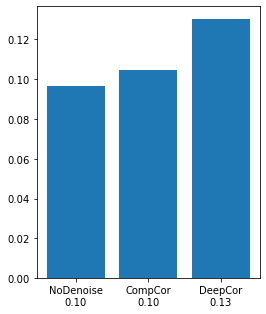

In [54]:
ys = corr_res.mean(axis=0).mean(axis=0)
print(ys)
plt.figure(figsize=(4,5))
xs = [0,1,2]
plt.bar(xs,ys)
plt.xticks(xs,labels=[f'NoDenoise\n{ys[0]:.2f}',f'CompCor\n{ys[1]:.2f}',f'DeepCor\n{ys[2]:.2f}'])

In [22]:
corr_res.shape

(10, 1, 3)

In [75]:
def pretty_t_test(vec1,vec2,ttl):
    from scipy.stats import ttest_rel
    #vec1 = vec_compcor
    #vec2 = vec_ffa
    #ttl = 'compcor > nodenoise: '
    t,p = ttest_rel(vec1,vec2)
    degf = len(vec1)-1
    diff = vec1.mean()-vec2.mean()
    

    print(f'{ttl} ΔM={diff:.2f}, t({int(degf)}) = {t:.2f}, p = {p:.3f}')

In [76]:
vec_ffa = corr_res.mean(axis=1)[:,0]
vec_compcor = corr_res.mean(axis=1)[:,1]
vec_deepcor = corr_res.mean(axis=1)[:,2]

In [77]:
pretty_t_test(vec_compcor,vec_ffa,'CompCor > NoDenoise: ')
pretty_t_test(vec_deepcor,vec_ffa,'DeepCor > NoDenoise: ')
pretty_t_test(vec_deepcor,vec_compcor,'DeepCor > CompCor: ')

CompCor > NoDenoise:  ΔM=0.01, t(9) = 0.70, p = 0.501
DeepCor > NoDenoise:  ΔM=0.03, t(9) = 1.39, p = 0.199
DeepCor > CompCor:  ΔM=0.03, t(9) = 1.41, p = 0.192


In [78]:
def plot_scatter(vec1,vec2,xlabel='',ylabel='',title=''):
#    plt.figure(figsize=(8, 6))
    plt.scatter(vec1, vec2, color='blue', label='Data points',s=150)
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)

    # Adding the parity line (where y = x)
    # Determine the limits for the line based on the data range:
    min_val = min(np.min(vec1), np.min(vec2))
    max_val = max(np.max(vec1), np.max(vec2))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Parity line (y=x)')

    # Add labels and title
    plt.xlabel(xlabel,fontsize=16,fontweight='bold')
    plt.ylabel(ylabel,fontsize=16,fontweight='bold')
    plt.legend()
    plt.grid(True)
    #plt.show()


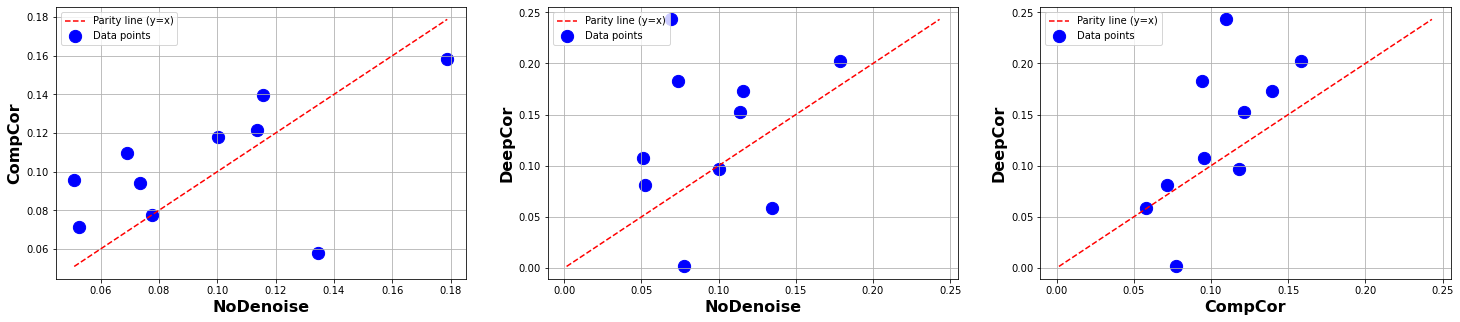

In [79]:
plt.figure(figsize=(25,5))
plt.subplot(1,3,1);plot_scatter(vec_ffa,vec_compcor,xlabel='NoDenoise',ylabel='CompCor',title='')
plt.subplot(1,3,2);plot_scatter(vec_ffa,vec_deepcor,xlabel='NoDenoise',ylabel='DeepCor',title='')
plt.subplot(1,3,3);plot_scatter(vec_compcor,vec_deepcor,xlabel='CompCor',ylabel='DeepCor',title='')